<a href="https://colab.research.google.com/github/tiboas/End-to-end-Learning/blob/main/End_to_end_Learning_AWGN_channel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# End-to-end Learning using Neural Networks
This notebook uses an autoencoder structure to learn how to communicate over a channel.Here we show learning for the AWGN channel with discrete modulation.

This is a tutorial-like implementation of a basic case for the method used in our publications: 

[1] Karanov, B., Chagnon, M., Thouin, F., Eriksson, T. A., Bülow, H., Lavery, D., … & Schmalen, L. (2018). End-to-end deep learning of optical fiber communications. Journal of Lightwave Technology, 36(20), 4843-4855.

[2] Jones, R. T., Eriksson, T. A., Yankov, M. P., & Zibar, D. (2018, September). Deep learning of geometric constellation shaping including fiber nonlinearities. In 2018 European Conference on Optical Communication (ECOC)

Implements a custom layer for the AWGN channel using the Keras backend.

In [ ]:
import numpy as np
from keras.utils import to_categorical
from keras import Sequential
from keras.layers import Dense, Flatten, Dropout, Lambda
import keras as keras
from tensorflow.keras import backend as K
import tensorflow as tf
from keras import backend as K

from keras.models import Model
import matplotlib.pyplot as plt
from scipy import optimize
 
from IPython.core.display import HTML
from IPython.core.display import Video

from matplotlib.colors import LinearSegmentedColormap

In [ ]:
#Using camera from celluloid to construct videos to show how the constellations evolve during training
!pip install celluloid
import celluloid
from celluloid import Camera # getting the camera

In [ ]:
#Settings:
Nepochs = 60
Nsamples = 50000
Nsamples_validate = 200000
M = 64 #Constellation size

# SNR for training
SNR_train = 16

# Standard deviation of the noise:
AWGN_sigma = np.sqrt(1 / (2 * 10 ** (SNR_train / 10)))


In [ ]:
# Power normalization for training:
def normalization(x):
    return x / K.sqrt(2 * (K.mean(x ** 2)))
    
# AWGN channel
def AWGN(x, sigma):
    noise = K.random_normal(K.shape(x), mean=0.0, stddev=sigma)
    y = x + noise
    return y

# Define the autoencoder model
* Here we use a Lambda-layer to call the normalization and the AWGN noise addition stage. 
* Note that we need to run with quite large batch-size in order for the normalization to be correct.

In [ ]:
N_units = 128;
inputs = keras.Input(shape=(M,))

#Encoder
x = Dense(4*N_units, activation="relu",kernel_initializer='he_normal')(inputs)
x = Dense(2*N_units, activation="relu",  kernel_initializer='he_normal')(x)
x = Dense(N_units, activation="relu",   kernel_initializer='he_normal')(x)
x = Dense(2, activation="linear",   kernel_initializer='random_normal', bias_initializer='zeros')(x)

# AWGN channel
x_normalized = Lambda(normalization)(x)
y = Lambda(AWGN, arguments={'sigma': AWGN_sigma})(x_normalized)

# Decoder
yhat = Dense(N_units, activation="relu",kernel_initializer='he_normal')(y)
yhat = Dense(2*N_units, activation="relu",kernel_initializer='he_normal')(yhat)
yhat = Dense(4*N_units, activation="relu",kernel_initializer='he_normal')(yhat)
outputs = Dense(M, activation="softmax")(yhat)

model = keras.Model(inputs=inputs, outputs=outputs, name="AWGNchannelEncoder")

In [ ]:
# Compile the model:
model.compile(
    loss="categorical_crossentropy",
    optimizer=keras.optimizers.Adam(learning_rate=0.001, beta_1= 0.95,beta_2=0.99),
    metrics=["accuracy"],
)

# Train the model
* Run one epoch at the time so that we can extract the constellation after each epoch.
* New random inputs are generated each epoch

40/40 [==============================] - 1s 11ms/step - loss: 3.1339 - accuracy: 0.1634 - val_loss: 1.8166 - val_accuracy: 0.2974
Setting LR to: 0.000985
40/40 [==============================] - 0s 6ms/step - loss: 1.6994 - accuracy: 0.3203 - val_loss: 1.6590 - val_accuracy: 0.3420
Setting LR to: 0.000970225
40/40 [==============================] - 0s 6ms/step - loss: 1.5814 - accuracy: 0.3625 - val_loss: 1.5328 - val_accuracy: 0.3910
Setting LR to: 0.00095567165
40/40 [==============================] - 0s 6ms/step - loss: 1.4478 - accuracy: 0.4505 - val_loss: 1.3321 - val_accuracy: 0.5141
Setting LR to: 0.00094133656
40/40 [==============================] - 0s 6ms/step - loss: 1.1942 - accuracy: 0.5642 - val_loss: 1.0627 - val_accuracy: 0.6092
Setting LR to: 0.0009272165
40/40 [==============================] - 0s 6ms/step - loss: 0.9538 - accuracy: 0.6501 - val_loss: 0.8833 - val_accuracy: 0.6804
Setting LR to: 0.00091330823
40/40 [==============================] - 0s 5ms/step - loss

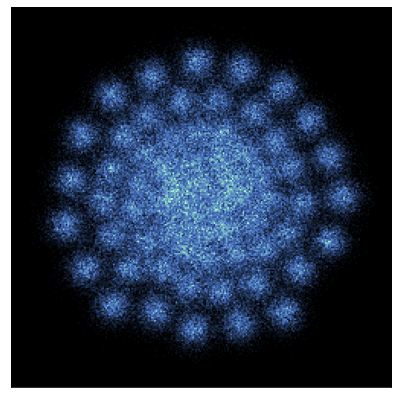

In [ ]:
#Figure and camera to create animation that shows the constellation updating:
fig = plt.figure(figsize=(7,7))
camera = Camera(fig)

#Loop over epochs:
acc = np.zeros((Nepochs))
acc_val = np.zeros((Nepochs))
for k in range(Nepochs):

  ##############################################
  # Encoder + AWGN channel visualization:
  ##############################################
  #Save the channel output (i.e. the encoder  + AWGN channel):
  XX = model.input 
  YY = model.layers[6].output
  encoderPlusChannel_model = Model(XX, YY)

  #Generate random inputs:
  N = np.random.randint(0,M,Nsamples_validate) # *4 since 4 16QAM has 4 bits/symbol
  N_ohe = to_categorical(N)
  encoderPlusChannel_output = encoderPlusChannel_model.predict(N_ohe, batch_size=np.int32(len(N_ohe)/4))
  
  #To visualize the output of the channel, a 2D histogram is used:
  heatmap, xedges, yedges = np.histogram2d(encoderPlusChannel_output[:,0], encoderPlusChannel_output[:,1], bins=250, range=[[-2,2],[-2,2]])
  extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]
  plt.imshow(heatmap.T, extent=extent, origin='lower',cmap=LinearSegmentedColormap.from_list('my_cmap', ['#000000','#4770BD','#A4F7C9','#E4FFD0'], N=250))
  plt.xticks([])
  plt.yticks([])
  camera.snap() #Save the image for this epoch.

  ##############################################
  # Model training
  ##############################################
  #Generate new random inputs for each epoch:
  N = np.random.randint(0,M,Nsamples) # *4 since 4 16QAM has 4 bits/symbol
  N_ohe = to_categorical(N)
  history = model.fit(N_ohe, N_ohe, batch_size=np.int32(Nsamples/50), epochs=1, validation_split=0.2)
  acc[k] = np.array(history.history['accuracy'])
  acc_val[k] = np.array(history.history['val_accuracy'])

  #Decrease LR ech epoch:
  K.set_value(model.optimizer.learning_rate, K.get_value(model.optimizer.learning_rate) * 0.985)
  print('Setting LR to: ' + str(K.get_value(model.optimizer.learning_rate)))

# Plot training and validation accuracy
* As expect we do not see any overfitting since we are generating new inputs every epoch

Text(0.5, 0, 'Epoch #')

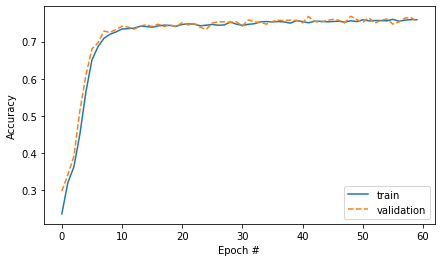

In [ ]:
#Plot training and validation accuracy:
plt.figure(figsize=(7,4))
plt.plot( acc)
plt.plot( acc_val,'--')
plt.legend(['train','validation'])
plt.ylabel('Accuracy')
plt.xlabel('Epoch #')

# Visualize constellation evolvment over epochs


In [ ]:
animation = camera.animate(repeat=True) # animation ready
animation.save('training.mp4')

###### This works best in notebook ###############
#video = HTML(animation.to_html5_video()) # displaying the animation
#video

######  To view video on website:  ###############
vid = Video("training.mp4", embed=True)
vid

# Calculate mutual information (MI)
* The enconder outputs are used
* For simplicity of the MI calculations the decoder part is omitted. 
  * However, note that it is possible to use the decoder outputs to estimate the MI. This can be especially useful if the channel is unkown. 
* The MI is compared to 64QAM and the AWGN capacity

In [ ]:
def noiseScaling(X,Y,h):
  return np.matmul((h*X-Y), (h*X-Y).conj().transpose())

def calcMI(X,Y, const, P):
  realmin = np.finfo(float).tiny #define a min value to avoid dividing by 0
  n = len(X)
  M = len(const)

  #Normalize X, Y, and the constellation:
  X = X/np.sqrt(np.mean(np.abs(X)**2))
  Y = Y/np.sqrt(np.mean(np.abs(Y)**2))
  const = const/np.sqrt(np.mean(np.abs(const)**2))

  #Scale the signal with respect to signal+noise:
  h_min = optimize.fminbound(noiseScaling, 0, 2.5, xtol=1e-6, maxfun=500,args=(X,Y,))
  N0 = np.real((1-h_min**2)/(h_min**2))
  Y = Y/h_min

  #Calculate the mutual information:
  qYonX = (1/(np.pi*N0)*np.exp((-(np.real(Y)-np.real(X))**2-(np.imag(Y)-np.imag(X))**2)/N0))
  qY = 0
  for i in range(M):
    qY = qY + P[i]*(1/(np.pi*N0)*np.exp((-(np.real(Y)-np.real(const[i]))**2-(np.imag(Y)-np.imag(const[i]))**2)/N0))
  qY = np.real(qY)
  qYonX = np.real(qYonX)
  MI=1/n*np.sum(np.log2(np.maximum(qYonX,realmin)/np.maximum(qY,realmin)))
  return MI

(-1.8039998892504268,
 1.8633375553659344,
 -1.771064594320326,
 1.8915589076224644)

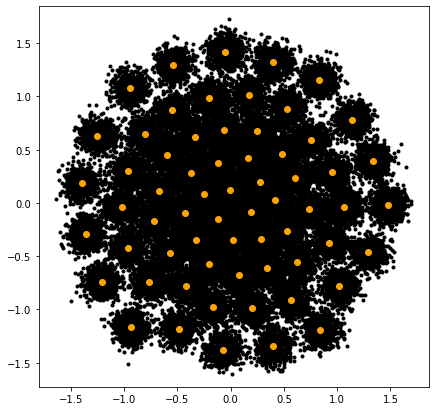

In [ ]:
# Get the encoder outputs:
XX = model.input 
YY = model.layers[4].output #Encoder outputs
encoderOutput = Model(XX, YY)

# To get the constellation, we input each of the M possible inputs to the enconder and save the output:
N = np.array(range(M)) 
N_ohe = to_categorical(N)
const = encoderOutput.predict(N_ohe, batch_size=np.int32(len(N_ohe)/4))
const = const[:,0] + 1j*const[:,1]
const= const-np.mean(const) #substract the mean from the cosntellation
const = const/np.sqrt(np.sum(np.abs(const)**2)/len(const)) #Normalize the constellation

#############################################
# Visualize the constellation means with and without noise
#############################################
Nsamples_MI = 50000
S = np.random.randint(0,len(const),Nsamples_MI) #Generate symbol indices 

SNRdB= 25;
SNR = 10**(SNRdB/10)
x = const[S]
Esig=np.sum(np.abs(x)**2)/len(x);
y = x + np.sqrt(Esig/(SNR/2))*(np.random.randn(len(x))+1j*np.random.randn(len(x))); 
plt.figure(figsize=(7,7))
plt.plot(y.real,y.imag,'k.')
plt.plot(const.real, const.imag,'o',color='orange')
plt.axis('equal')

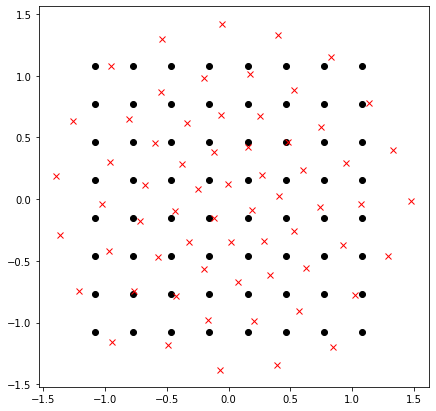

In [ ]:
#Generate 64QAM constellation:
constQAM = []
for ii in range(-7,7+1,2):
  for jj in range(-7,7+1,2):
    constQAM = np.append(constQAM, ii+1j*jj)
constQAM = constQAM/np.sqrt(np.sum(np.abs(constQAM)**2)/len(constQAM))

# Visuzalize difference between 64QAM and the NN-learned constellation:
plt.figure(figsize=(7,7))
plt.plot(constQAM.real,constQAM.imag,'ko',markeredgecolor='k')
plt.plot(const.real,const.imag,'x',color='red', markeredgecolor='red')

#############################################
# Sweep over SNRs and calculate MI
#############################################
NsymbolsSNRsweep= 50000
PQAM =  np.ones((len(constQAM)))/len(constQAM) 

SNRdB_vector = range(0,35,1)
MI = []
MI_AOC = []
for SNRdB in SNRdB_vector:
    SNR = 10**(SNRdB/10)

    #64QAM
    s = np.random.randint(0,len(constQAM),NsymbolsSNRsweep)
    x = constQAM[s]
    _,P = np.unique(x,return_counts=True)
    P = P / np.sum(P)
    y = x + np.sqrt(1/(2*SNR))*(np.random.randn(len(x))+1j*np.random.randn(len(x))); 
    MIthis = calcMI(x,y,constQAM,P)
    MI = np.append(MI,MIthis)

    #NN-learnt Constellation
    sAOC = np.random.randint(0,len(const),NsymbolsSNRsweep)
    xAOC= const[S]
    _,PAOC = np.unique(xAOC,return_counts=True)
    PAOC= PAOC / np.sum(PAOC)
    yAOX = xAOC +np.sqrt(1/(2*SNR))*(np.random.randn(len(xAOC))+1j*np.random.randn(len(xAOC))); 
    MIthis_AOC = calcMI(xAOC,yAOX,const,PAOC)
    MI_AOC = np.append(MI_AOC,MIthis_AOC)

<Figure size 432x288 with 0 Axes>

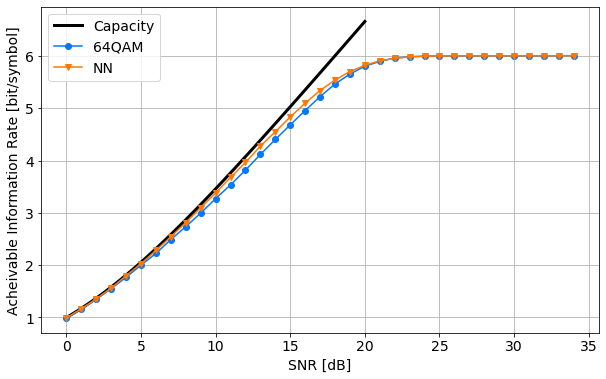

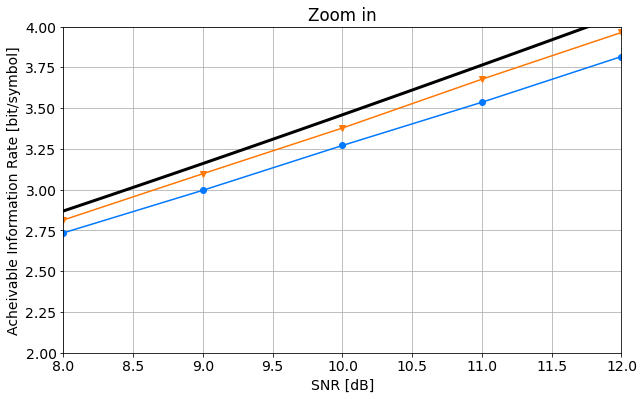

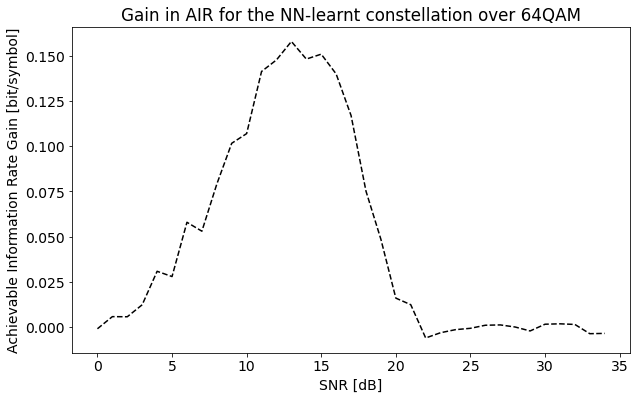

In [ ]:
# Plot the MI results
plt.figure()
SNRdBsh = np.linspace(0,20,100)
SNR_sh = 10**(SNRdBsh/10)
C = np.log2(1 + SNR_sh)
pColor  = np.array([255,120,5])/255
pColor2 = np.array([0,120,255])/255
plt.rcParams.update({'font.size': 14}) #set fontsize
plt.figure(figsize=(10,6))
plt.plot(SNRdBsh,C,'k', linewidth=3)
plt.plot(np.array(SNRdB_vector),MI,'o-', color=pColor2)
plt.plot(np.array(SNRdB_vector),MI_AOC,'v-',color=pColor)
plt.grid('minor')
plt.legend(['Capacity','64QAM','NN'])
plt.ylabel('Acheivable Information Rate [bit/symbol]')
plt.xlabel('SNR [dB]')

plt.figure(figsize=(10,6))
plt.plot(SNRdBsh,C,'k', linewidth=3)
plt.plot(np.array(SNRdB_vector),MI,'o-', color=pColor2)
plt.plot(np.array(SNRdB_vector),MI_AOC,'v-',color=pColor)
plt.grid('minor')
plt.xlim([8, 12])
plt.ylim([2,4])
plt.ylabel('Acheivable Information Rate [bit/symbol]')
plt.title('Zoom in')
plt.xlabel('SNR [dB]')

plt.figure(figsize=(10,6))
plt.plot(np.array(SNRdB_vector),MI_AOC-MI,'k--')
plt.xlabel('SNR [dB]')
plt.ylabel('Achievable Information Rate Gain [bit/symbol]')
plt.title('Gain in AIR for the NN-learnt constellation over 64QAM')
plt.plot([])
